# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [192]:
# can comment out after executing
# !unzip -n processed-celeba-small.zip

In [193]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [194]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [195]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    # transforms
    train_transform = transforms.Compose([transforms.Resize((image_size, image_size)),
                                     transforms.ToTensor()])
    
    train_data = datasets.ImageFolder(data_dir, transform=train_transform)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           shuffle=True)
    
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [255]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

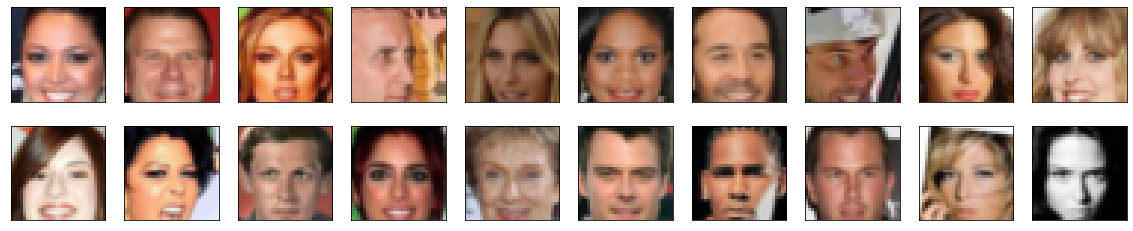

In [256]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [257]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [258]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [259]:
import torch.nn as nn
import torch.nn.functional as F

In [260]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [261]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # all hidden layers + leaky relu activation
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        # flatten
        x = x.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        x = self.fc(x)  
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [262]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [263]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        # fully-connected + reshape 
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        # last layer + tanh activation
        x = self.t_conv3(x)
        x = torch.tanh(x)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [264]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    std_dev = 0.02
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, std_dev)

        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        nn.init.normal_(m.weight.data, 1.0, std_dev)
        nn.init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [265]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [266]:
# Define model hyperparams
d_conv_dim = 64 
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [267]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [268]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    return torch.mean((D_out - 1)**2)

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    return torch.mean(D_out**2)

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [269]:
import torch.optim as optim

# params
lr=0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [270]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            # 1. Train with fake images and flipped labels
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [276]:
# set number of epochs 
n_epochs = 60


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   60] | d_loss: 0.0571 | g_loss: 0.8607
Epoch [    1/   60] | d_loss: 0.0387 | g_loss: 0.8445
Epoch [    1/   60] | d_loss: 0.2921 | g_loss: 0.4702
Epoch [    1/   60] | d_loss: 0.2408 | g_loss: 1.2554
Epoch [    1/   60] | d_loss: 0.0509 | g_loss: 1.0070
Epoch [    1/   60] | d_loss: 0.0536 | g_loss: 1.0035
Epoch [    1/   60] | d_loss: 0.0908 | g_loss: 1.2986
Epoch [    1/   60] | d_loss: 0.1166 | g_loss: 1.3182
Epoch [    1/   60] | d_loss: 0.0460 | g_loss: 1.1931
Epoch [    1/   60] | d_loss: 0.0308 | g_loss: 0.9242
Epoch [    1/   60] | d_loss: 0.0519 | g_loss: 0.7440
Epoch [    1/   60] | d_loss: 0.1275 | g_loss: 1.0149
Epoch [    1/   60] | d_loss: 0.0254 | g_loss: 1.0510
Epoch [    1/   60] | d_loss: 0.0927 | g_loss: 0.8515
Epoch [    1/   60] | d_loss: 0.0423 | g_loss: 0.9822
Epoch [    1/   60] | d_loss: 0.0340 | g_loss: 0.9301
Epoch [    1/   60] | d_loss: 0.0782 | g_loss: 0.6764
Epoch [    1/   60] | d_loss: 0.0577 | g_loss: 0.7641
Epoch [    1/   60] | d_loss

Epoch [    3/   60] | d_loss: 0.0439 | g_loss: 1.0190
Epoch [    3/   60] | d_loss: 0.0949 | g_loss: 1.3339
Epoch [    3/   60] | d_loss: 0.0426 | g_loss: 0.7975
Epoch [    3/   60] | d_loss: 0.3395 | g_loss: 0.5212
Epoch [    3/   60] | d_loss: 0.0556 | g_loss: 1.0398
Epoch [    3/   60] | d_loss: 0.0656 | g_loss: 1.2593
Epoch [    3/   60] | d_loss: 0.0657 | g_loss: 0.8542
Epoch [    3/   60] | d_loss: 0.0399 | g_loss: 0.6426
Epoch [    3/   60] | d_loss: 0.0290 | g_loss: 0.7568
Epoch [    3/   60] | d_loss: 0.0413 | g_loss: 1.1496
Epoch [    3/   60] | d_loss: 0.0496 | g_loss: 0.7380
Epoch [    3/   60] | d_loss: 0.0751 | g_loss: 0.7395
Epoch [    3/   60] | d_loss: 0.1331 | g_loss: 1.6294
Epoch [    3/   60] | d_loss: 0.6633 | g_loss: 0.3233
Epoch [    3/   60] | d_loss: 0.1446 | g_loss: 0.9832
Epoch [    3/   60] | d_loss: 0.0932 | g_loss: 0.8801
Epoch [    3/   60] | d_loss: 0.0600 | g_loss: 0.8833
Epoch [    3/   60] | d_loss: 0.0921 | g_loss: 0.7668
Epoch [    3/   60] | d_loss

Epoch [    6/   60] | d_loss: 0.0645 | g_loss: 0.4463
Epoch [    6/   60] | d_loss: 0.2183 | g_loss: 1.7933
Epoch [    6/   60] | d_loss: 0.0757 | g_loss: 0.9036
Epoch [    6/   60] | d_loss: 0.0613 | g_loss: 1.0681
Epoch [    6/   60] | d_loss: 0.0292 | g_loss: 1.2544
Epoch [    6/   60] | d_loss: 0.0241 | g_loss: 1.0267
Epoch [    6/   60] | d_loss: 0.0782 | g_loss: 0.8654
Epoch [    6/   60] | d_loss: 0.0417 | g_loss: 1.3270
Epoch [    6/   60] | d_loss: 0.1214 | g_loss: 0.9100
Epoch [    6/   60] | d_loss: 0.0542 | g_loss: 0.7609
Epoch [    6/   60] | d_loss: 0.1125 | g_loss: 1.1758
Epoch [    6/   60] | d_loss: 0.0421 | g_loss: 1.0480
Epoch [    6/   60] | d_loss: 0.0335 | g_loss: 0.9979
Epoch [    6/   60] | d_loss: 0.0950 | g_loss: 0.8469
Epoch [    6/   60] | d_loss: 0.0580 | g_loss: 0.9941
Epoch [    6/   60] | d_loss: 0.0369 | g_loss: 0.7358
Epoch [    6/   60] | d_loss: 0.0881 | g_loss: 0.7659
Epoch [    6/   60] | d_loss: 0.1687 | g_loss: 0.9203
Epoch [    6/   60] | d_loss

Epoch [    9/   60] | d_loss: 0.0461 | g_loss: 0.7180
Epoch [    9/   60] | d_loss: 0.0468 | g_loss: 0.7270
Epoch [    9/   60] | d_loss: 0.0720 | g_loss: 0.8512
Epoch [    9/   60] | d_loss: 0.3193 | g_loss: 1.4099
Epoch [    9/   60] | d_loss: 0.0386 | g_loss: 1.2041
Epoch [    9/   60] | d_loss: 0.0454 | g_loss: 0.8115
Epoch [    9/   60] | d_loss: 0.0732 | g_loss: 0.8043
Epoch [    9/   60] | d_loss: 0.0266 | g_loss: 0.9258
Epoch [    9/   60] | d_loss: 0.2161 | g_loss: 0.7057
Epoch [    9/   60] | d_loss: 0.0312 | g_loss: 0.9047
Epoch [    9/   60] | d_loss: 0.0669 | g_loss: 1.0769
Epoch [    9/   60] | d_loss: 0.0719 | g_loss: 0.7277
Epoch [    9/   60] | d_loss: 0.0562 | g_loss: 1.0618
Epoch [    9/   60] | d_loss: 0.0922 | g_loss: 0.9676
Epoch [    9/   60] | d_loss: 0.0599 | g_loss: 1.0357
Epoch [    9/   60] | d_loss: 0.0779 | g_loss: 0.6320
Epoch [    9/   60] | d_loss: 0.0694 | g_loss: 0.8731
Epoch [    9/   60] | d_loss: 0.0499 | g_loss: 1.2002
Epoch [    9/   60] | d_loss

Epoch [   11/   60] | d_loss: 0.0570 | g_loss: 0.5974
Epoch [   11/   60] | d_loss: 0.0510 | g_loss: 0.6294
Epoch [   11/   60] | d_loss: 0.0489 | g_loss: 0.9678
Epoch [   11/   60] | d_loss: 0.0562 | g_loss: 1.1645
Epoch [   11/   60] | d_loss: 0.0363 | g_loss: 0.5998
Epoch [   11/   60] | d_loss: 0.0510 | g_loss: 1.1026
Epoch [   11/   60] | d_loss: 0.1173 | g_loss: 1.2743
Epoch [   11/   60] | d_loss: 0.0788 | g_loss: 0.8031
Epoch [   11/   60] | d_loss: 0.0720 | g_loss: 0.7596
Epoch [   11/   60] | d_loss: 0.0398 | g_loss: 0.5019
Epoch [   11/   60] | d_loss: 0.0497 | g_loss: 1.1324
Epoch [   11/   60] | d_loss: 0.0309 | g_loss: 1.4145
Epoch [   11/   60] | d_loss: 0.1409 | g_loss: 0.3729
Epoch [   11/   60] | d_loss: 0.1087 | g_loss: 0.6049
Epoch [   11/   60] | d_loss: 0.0453 | g_loss: 1.2465
Epoch [   11/   60] | d_loss: 0.0375 | g_loss: 0.7767
Epoch [   11/   60] | d_loss: 0.0619 | g_loss: 0.6526
Epoch [   11/   60] | d_loss: 0.1518 | g_loss: 1.2114
Epoch [   11/   60] | d_loss

Epoch [   14/   60] | d_loss: 0.0803 | g_loss: 1.3410
Epoch [   14/   60] | d_loss: 0.0283 | g_loss: 0.8010
Epoch [   14/   60] | d_loss: 0.0924 | g_loss: 0.9497
Epoch [   14/   60] | d_loss: 0.0537 | g_loss: 0.7638
Epoch [   14/   60] | d_loss: 0.0822 | g_loss: 0.6448
Epoch [   14/   60] | d_loss: 0.0378 | g_loss: 1.2165
Epoch [   14/   60] | d_loss: 0.0776 | g_loss: 1.2344
Epoch [   14/   60] | d_loss: 0.0393 | g_loss: 0.7026
Epoch [   14/   60] | d_loss: 0.1587 | g_loss: 0.8217
Epoch [   14/   60] | d_loss: 0.1290 | g_loss: 0.6736
Epoch [   14/   60] | d_loss: 0.0743 | g_loss: 0.5895
Epoch [   14/   60] | d_loss: 0.0282 | g_loss: 1.2641
Epoch [   14/   60] | d_loss: 0.0433 | g_loss: 1.1007
Epoch [   14/   60] | d_loss: 0.0371 | g_loss: 0.7587
Epoch [   14/   60] | d_loss: 0.1217 | g_loss: 0.6399
Epoch [   14/   60] | d_loss: 0.0593 | g_loss: 0.9992
Epoch [   14/   60] | d_loss: 0.0569 | g_loss: 0.9707
Epoch [   14/   60] | d_loss: 0.0719 | g_loss: 1.2540
Epoch [   14/   60] | d_loss

Epoch [   17/   60] | d_loss: 0.1448 | g_loss: 1.0661
Epoch [   17/   60] | d_loss: 0.0574 | g_loss: 0.6412
Epoch [   17/   60] | d_loss: 0.0852 | g_loss: 0.7218
Epoch [   17/   60] | d_loss: 0.0770 | g_loss: 0.9418
Epoch [   17/   60] | d_loss: 0.0509 | g_loss: 0.8555
Epoch [   17/   60] | d_loss: 0.1485 | g_loss: 1.3513
Epoch [   17/   60] | d_loss: 0.0722 | g_loss: 0.6389
Epoch [   17/   60] | d_loss: 0.0351 | g_loss: 0.9058
Epoch [   17/   60] | d_loss: 0.0513 | g_loss: 1.1673
Epoch [   17/   60] | d_loss: 0.1270 | g_loss: 0.7220
Epoch [   17/   60] | d_loss: 0.0986 | g_loss: 1.2822
Epoch [   17/   60] | d_loss: 0.0309 | g_loss: 1.1172
Epoch [   17/   60] | d_loss: 0.0869 | g_loss: 1.7795
Epoch [   17/   60] | d_loss: 0.0456 | g_loss: 0.9557
Epoch [   17/   60] | d_loss: 0.0374 | g_loss: 0.7683
Epoch [   17/   60] | d_loss: 0.0898 | g_loss: 0.7178
Epoch [   17/   60] | d_loss: 0.0451 | g_loss: 0.9896
Epoch [   17/   60] | d_loss: 0.0345 | g_loss: 0.9354
Epoch [   17/   60] | d_loss

Epoch [   19/   60] | d_loss: 0.1130 | g_loss: 0.6731
Epoch [   19/   60] | d_loss: 0.0747 | g_loss: 1.0700
Epoch [   19/   60] | d_loss: 0.0235 | g_loss: 0.8761
Epoch [   19/   60] | d_loss: 0.0437 | g_loss: 0.5616
Epoch [   19/   60] | d_loss: 0.0329 | g_loss: 0.9818
Epoch [   19/   60] | d_loss: 0.0547 | g_loss: 0.9161
Epoch [   19/   60] | d_loss: 0.0768 | g_loss: 0.9696
Epoch [   19/   60] | d_loss: 0.0306 | g_loss: 1.1473
Epoch [   19/   60] | d_loss: 0.0772 | g_loss: 0.7161
Epoch [   19/   60] | d_loss: 0.1099 | g_loss: 0.9371
Epoch [   19/   60] | d_loss: 0.0328 | g_loss: 0.9543
Epoch [   19/   60] | d_loss: 0.0529 | g_loss: 0.7512
Epoch [   19/   60] | d_loss: 0.0621 | g_loss: 0.8072
Epoch [   19/   60] | d_loss: 0.0770 | g_loss: 0.8647
Epoch [   19/   60] | d_loss: 0.1515 | g_loss: 0.7428
Epoch [   19/   60] | d_loss: 0.0500 | g_loss: 1.2467
Epoch [   19/   60] | d_loss: 0.0240 | g_loss: 1.1745
Epoch [   19/   60] | d_loss: 0.0478 | g_loss: 1.1551
Epoch [   19/   60] | d_loss

Epoch [   22/   60] | d_loss: 0.0333 | g_loss: 0.9574
Epoch [   22/   60] | d_loss: 0.0292 | g_loss: 0.6975
Epoch [   22/   60] | d_loss: 0.0824 | g_loss: 1.3524
Epoch [   22/   60] | d_loss: 0.1000 | g_loss: 1.1445
Epoch [   22/   60] | d_loss: 0.0648 | g_loss: 0.7052
Epoch [   22/   60] | d_loss: 0.0331 | g_loss: 1.3237
Epoch [   22/   60] | d_loss: 0.1147 | g_loss: 0.7348
Epoch [   22/   60] | d_loss: 0.0486 | g_loss: 1.0338
Epoch [   22/   60] | d_loss: 0.1246 | g_loss: 1.2336
Epoch [   22/   60] | d_loss: 0.0431 | g_loss: 1.1468
Epoch [   22/   60] | d_loss: 0.0359 | g_loss: 0.9662
Epoch [   22/   60] | d_loss: 0.0422 | g_loss: 0.8406
Epoch [   22/   60] | d_loss: 0.0901 | g_loss: 0.9197
Epoch [   22/   60] | d_loss: 0.0551 | g_loss: 1.0110
Epoch [   22/   60] | d_loss: 0.0511 | g_loss: 1.2551
Epoch [   22/   60] | d_loss: 0.0730 | g_loss: 1.0604
Epoch [   22/   60] | d_loss: 0.0789 | g_loss: 0.9484
Epoch [   22/   60] | d_loss: 0.0419 | g_loss: 0.7474
Epoch [   22/   60] | d_loss

Epoch [   25/   60] | d_loss: 0.1352 | g_loss: 1.7380
Epoch [   25/   60] | d_loss: 0.0367 | g_loss: 0.8696
Epoch [   25/   60] | d_loss: 0.0608 | g_loss: 1.0407
Epoch [   25/   60] | d_loss: 0.0844 | g_loss: 1.4455
Epoch [   25/   60] | d_loss: 0.0321 | g_loss: 0.7966
Epoch [   25/   60] | d_loss: 0.0323 | g_loss: 1.0880
Epoch [   25/   60] | d_loss: 0.0263 | g_loss: 1.5582
Epoch [   25/   60] | d_loss: 0.0537 | g_loss: 1.1274
Epoch [   25/   60] | d_loss: 0.0705 | g_loss: 0.9077
Epoch [   25/   60] | d_loss: 0.1987 | g_loss: 0.5905
Epoch [   25/   60] | d_loss: 0.1091 | g_loss: 0.5594
Epoch [   25/   60] | d_loss: 0.0394 | g_loss: 1.1406
Epoch [   25/   60] | d_loss: 0.0247 | g_loss: 0.8545
Epoch [   25/   60] | d_loss: 0.0295 | g_loss: 1.0334
Epoch [   25/   60] | d_loss: 0.0579 | g_loss: 0.8032
Epoch [   25/   60] | d_loss: 0.0789 | g_loss: 0.8501
Epoch [   25/   60] | d_loss: 0.0300 | g_loss: 0.5721
Epoch [   25/   60] | d_loss: 0.2153 | g_loss: 0.6897
Epoch [   25/   60] | d_loss

Epoch [   27/   60] | d_loss: 0.0938 | g_loss: 0.7257
Epoch [   27/   60] | d_loss: 0.0438 | g_loss: 1.0714
Epoch [   27/   60] | d_loss: 0.0419 | g_loss: 0.5531
Epoch [   27/   60] | d_loss: 0.1331 | g_loss: 0.9070
Epoch [   27/   60] | d_loss: 0.1066 | g_loss: 1.5153
Epoch [   27/   60] | d_loss: 0.0955 | g_loss: 0.7955
Epoch [   27/   60] | d_loss: 0.0405 | g_loss: 0.9116
Epoch [   27/   60] | d_loss: 0.0493 | g_loss: 0.6806
Epoch [   27/   60] | d_loss: 0.0435 | g_loss: 0.9511
Epoch [   27/   60] | d_loss: 0.0794 | g_loss: 1.1042
Epoch [   27/   60] | d_loss: 0.0227 | g_loss: 0.7769
Epoch [   27/   60] | d_loss: 0.1143 | g_loss: 0.6282
Epoch [   27/   60] | d_loss: 0.0229 | g_loss: 0.9922
Epoch [   27/   60] | d_loss: 0.0412 | g_loss: 0.6146
Epoch [   27/   60] | d_loss: 0.0322 | g_loss: 0.8254
Epoch [   27/   60] | d_loss: 0.0672 | g_loss: 0.7913
Epoch [   27/   60] | d_loss: 0.0316 | g_loss: 1.1094
Epoch [   27/   60] | d_loss: 0.0431 | g_loss: 1.0225
Epoch [   27/   60] | d_loss

Epoch [   30/   60] | d_loss: 0.0350 | g_loss: 0.9001
Epoch [   30/   60] | d_loss: 0.0324 | g_loss: 1.1855
Epoch [   30/   60] | d_loss: 0.0733 | g_loss: 0.9562
Epoch [   30/   60] | d_loss: 0.0309 | g_loss: 0.7619
Epoch [   30/   60] | d_loss: 0.0388 | g_loss: 1.6610
Epoch [   30/   60] | d_loss: 0.0646 | g_loss: 0.9356
Epoch [   30/   60] | d_loss: 0.0694 | g_loss: 0.9555
Epoch [   30/   60] | d_loss: 0.0384 | g_loss: 0.6619
Epoch [   30/   60] | d_loss: 0.0219 | g_loss: 0.8015
Epoch [   30/   60] | d_loss: 0.1610 | g_loss: 1.2217
Epoch [   30/   60] | d_loss: 0.0304 | g_loss: 0.6944
Epoch [   30/   60] | d_loss: 0.0359 | g_loss: 0.5411
Epoch [   30/   60] | d_loss: 0.3572 | g_loss: 0.5021
Epoch [   30/   60] | d_loss: 0.0654 | g_loss: 0.9550
Epoch [   30/   60] | d_loss: 0.1078 | g_loss: 0.5758
Epoch [   30/   60] | d_loss: 0.0302 | g_loss: 1.1569
Epoch [   30/   60] | d_loss: 0.0402 | g_loss: 0.7150
Epoch [   30/   60] | d_loss: 0.0403 | g_loss: 1.0677
Epoch [   30/   60] | d_loss

Epoch [   33/   60] | d_loss: 0.1417 | g_loss: 1.4294
Epoch [   33/   60] | d_loss: 0.0390 | g_loss: 0.7660
Epoch [   33/   60] | d_loss: 0.0448 | g_loss: 0.6692
Epoch [   33/   60] | d_loss: 0.0846 | g_loss: 0.8421
Epoch [   33/   60] | d_loss: 0.0329 | g_loss: 1.2093
Epoch [   33/   60] | d_loss: 0.0298 | g_loss: 1.1746
Epoch [   33/   60] | d_loss: 0.0358 | g_loss: 1.3349
Epoch [   33/   60] | d_loss: 0.0233 | g_loss: 0.9605
Epoch [   33/   60] | d_loss: 0.0216 | g_loss: 0.5434
Epoch [   33/   60] | d_loss: 0.0197 | g_loss: 1.0579
Epoch [   33/   60] | d_loss: 0.0339 | g_loss: 0.8307
Epoch [   33/   60] | d_loss: 0.0689 | g_loss: 0.7855
Epoch [   33/   60] | d_loss: 0.0531 | g_loss: 1.1761
Epoch [   33/   60] | d_loss: 0.0394 | g_loss: 1.0133
Epoch [   33/   60] | d_loss: 0.0540 | g_loss: 0.6197
Epoch [   33/   60] | d_loss: 0.0582 | g_loss: 0.7295
Epoch [   33/   60] | d_loss: 0.2410 | g_loss: 0.4535
Epoch [   33/   60] | d_loss: 0.0556 | g_loss: 1.1931
Epoch [   33/   60] | d_loss

Epoch [   35/   60] | d_loss: 0.1674 | g_loss: 0.6682
Epoch [   35/   60] | d_loss: 0.1062 | g_loss: 0.7391
Epoch [   35/   60] | d_loss: 0.1249 | g_loss: 0.7452
Epoch [   35/   60] | d_loss: 0.0237 | g_loss: 1.0974
Epoch [   35/   60] | d_loss: 0.0426 | g_loss: 1.1187
Epoch [   35/   60] | d_loss: 0.0410 | g_loss: 1.4111
Epoch [   35/   60] | d_loss: 0.0417 | g_loss: 0.7531
Epoch [   35/   60] | d_loss: 0.0450 | g_loss: 0.8943
Epoch [   35/   60] | d_loss: 0.0409 | g_loss: 1.3807
Epoch [   35/   60] | d_loss: 0.0748 | g_loss: 0.9842
Epoch [   35/   60] | d_loss: 0.0616 | g_loss: 0.7020
Epoch [   35/   60] | d_loss: 0.0596 | g_loss: 1.4700
Epoch [   35/   60] | d_loss: 0.0260 | g_loss: 1.7215
Epoch [   35/   60] | d_loss: 0.0585 | g_loss: 0.7548
Epoch [   35/   60] | d_loss: 0.1312 | g_loss: 0.9759
Epoch [   35/   60] | d_loss: 0.0325 | g_loss: 0.6514
Epoch [   35/   60] | d_loss: 0.0548 | g_loss: 1.3619
Epoch [   35/   60] | d_loss: 0.0841 | g_loss: 0.6198
Epoch [   35/   60] | d_loss

Epoch [   38/   60] | d_loss: 0.0596 | g_loss: 1.3097
Epoch [   38/   60] | d_loss: 0.0415 | g_loss: 0.8257
Epoch [   38/   60] | d_loss: 0.0933 | g_loss: 1.2487
Epoch [   38/   60] | d_loss: 0.0325 | g_loss: 0.9065
Epoch [   38/   60] | d_loss: 0.0164 | g_loss: 0.8736
Epoch [   38/   60] | d_loss: 0.1021 | g_loss: 1.3638
Epoch [   38/   60] | d_loss: 0.0555 | g_loss: 1.1344
Epoch [   38/   60] | d_loss: 0.1015 | g_loss: 0.6720
Epoch [   38/   60] | d_loss: 0.0498 | g_loss: 1.0888
Epoch [   38/   60] | d_loss: 0.0320 | g_loss: 1.0457
Epoch [   38/   60] | d_loss: 0.0371 | g_loss: 1.0376
Epoch [   38/   60] | d_loss: 0.2109 | g_loss: 0.8504
Epoch [   38/   60] | d_loss: 0.0246 | g_loss: 0.8711
Epoch [   38/   60] | d_loss: 0.1610 | g_loss: 1.4576
Epoch [   38/   60] | d_loss: 0.0402 | g_loss: 0.7439
Epoch [   38/   60] | d_loss: 0.0220 | g_loss: 1.3094
Epoch [   38/   60] | d_loss: 0.0379 | g_loss: 0.7250
Epoch [   38/   60] | d_loss: 0.0184 | g_loss: 0.8155
Epoch [   38/   60] | d_loss

Epoch [   41/   60] | d_loss: 0.0630 | g_loss: 1.2130
Epoch [   41/   60] | d_loss: 0.0721 | g_loss: 0.9403
Epoch [   41/   60] | d_loss: 0.0532 | g_loss: 0.5728
Epoch [   41/   60] | d_loss: 0.0565 | g_loss: 0.5582
Epoch [   41/   60] | d_loss: 0.0497 | g_loss: 0.7635
Epoch [   41/   60] | d_loss: 0.0553 | g_loss: 0.9670
Epoch [   41/   60] | d_loss: 0.0290 | g_loss: 0.5894
Epoch [   41/   60] | d_loss: 0.0675 | g_loss: 1.0736
Epoch [   41/   60] | d_loss: 0.0217 | g_loss: 1.3653
Epoch [   41/   60] | d_loss: 0.0435 | g_loss: 1.0661
Epoch [   41/   60] | d_loss: 0.0403 | g_loss: 0.7785
Epoch [   41/   60] | d_loss: 0.1176 | g_loss: 1.2635
Epoch [   41/   60] | d_loss: 0.0218 | g_loss: 0.8913
Epoch [   41/   60] | d_loss: 0.1404 | g_loss: 0.7248
Epoch [   41/   60] | d_loss: 0.0977 | g_loss: 1.0086
Epoch [   41/   60] | d_loss: 0.0296 | g_loss: 0.8148
Epoch [   41/   60] | d_loss: 0.0197 | g_loss: 1.0225
Epoch [   41/   60] | d_loss: 0.1794 | g_loss: 0.9370
Epoch [   41/   60] | d_loss

Epoch [   43/   60] | d_loss: 0.0981 | g_loss: 0.7219
Epoch [   43/   60] | d_loss: 0.1238 | g_loss: 1.4695
Epoch [   43/   60] | d_loss: 0.1366 | g_loss: 0.6056
Epoch [   43/   60] | d_loss: 0.0207 | g_loss: 1.1291
Epoch [   43/   60] | d_loss: 0.0562 | g_loss: 0.8593
Epoch [   43/   60] | d_loss: 0.1103 | g_loss: 0.7017
Epoch [   43/   60] | d_loss: 0.1222 | g_loss: 1.1957
Epoch [   43/   60] | d_loss: 0.0767 | g_loss: 0.7544
Epoch [   43/   60] | d_loss: 0.1535 | g_loss: 1.1769
Epoch [   43/   60] | d_loss: 0.0533 | g_loss: 0.9473
Epoch [   43/   60] | d_loss: 0.0758 | g_loss: 1.0936
Epoch [   43/   60] | d_loss: 0.0513 | g_loss: 1.3318
Epoch [   43/   60] | d_loss: 0.0272 | g_loss: 0.8213
Epoch [   43/   60] | d_loss: 0.0496 | g_loss: 0.6890
Epoch [   43/   60] | d_loss: 0.0735 | g_loss: 0.9657
Epoch [   43/   60] | d_loss: 0.0258 | g_loss: 0.5730
Epoch [   43/   60] | d_loss: 0.0270 | g_loss: 0.8815
Epoch [   43/   60] | d_loss: 0.0873 | g_loss: 0.7506
Epoch [   43/   60] | d_loss

Epoch [   46/   60] | d_loss: 0.0438 | g_loss: 0.9357
Epoch [   46/   60] | d_loss: 0.0653 | g_loss: 0.8422
Epoch [   46/   60] | d_loss: 0.0732 | g_loss: 0.9561
Epoch [   46/   60] | d_loss: 0.1339 | g_loss: 0.8079
Epoch [   46/   60] | d_loss: 0.0744 | g_loss: 0.9624
Epoch [   46/   60] | d_loss: 0.0315 | g_loss: 1.0732
Epoch [   46/   60] | d_loss: 0.0579 | g_loss: 1.1129
Epoch [   46/   60] | d_loss: 0.0406 | g_loss: 0.6312
Epoch [   46/   60] | d_loss: 0.1414 | g_loss: 1.0822
Epoch [   46/   60] | d_loss: 0.0865 | g_loss: 0.7241
Epoch [   46/   60] | d_loss: 0.0283 | g_loss: 1.2488
Epoch [   46/   60] | d_loss: 0.0349 | g_loss: 0.9083
Epoch [   46/   60] | d_loss: 0.0250 | g_loss: 1.0350
Epoch [   46/   60] | d_loss: 0.0218 | g_loss: 0.8561
Epoch [   46/   60] | d_loss: 0.0688 | g_loss: 1.0810
Epoch [   46/   60] | d_loss: 0.0772 | g_loss: 0.6904
Epoch [   46/   60] | d_loss: 0.0412 | g_loss: 0.3174
Epoch [   46/   60] | d_loss: 0.0260 | g_loss: 1.3470
Epoch [   46/   60] | d_loss

Epoch [   49/   60] | d_loss: 0.0229 | g_loss: 1.1625
Epoch [   49/   60] | d_loss: 0.0620 | g_loss: 0.8390
Epoch [   49/   60] | d_loss: 0.0240 | g_loss: 1.0065
Epoch [   49/   60] | d_loss: 0.0722 | g_loss: 0.5590
Epoch [   49/   60] | d_loss: 0.0328 | g_loss: 1.1170
Epoch [   49/   60] | d_loss: 0.0318 | g_loss: 0.8614
Epoch [   49/   60] | d_loss: 0.0758 | g_loss: 1.2024
Epoch [   49/   60] | d_loss: 0.0496 | g_loss: 0.8868
Epoch [   49/   60] | d_loss: 0.0523 | g_loss: 0.6002
Epoch [   49/   60] | d_loss: 0.0613 | g_loss: 0.5956
Epoch [   49/   60] | d_loss: 0.0304 | g_loss: 1.0703
Epoch [   49/   60] | d_loss: 0.0199 | g_loss: 0.9320
Epoch [   49/   60] | d_loss: 0.0703 | g_loss: 0.7354
Epoch [   49/   60] | d_loss: 0.0767 | g_loss: 0.8242
Epoch [   49/   60] | d_loss: 0.0174 | g_loss: 0.6928
Epoch [   49/   60] | d_loss: 0.0888 | g_loss: 1.2878
Epoch [   49/   60] | d_loss: 0.0268 | g_loss: 0.9496
Epoch [   49/   60] | d_loss: 0.0513 | g_loss: 1.0174
Epoch [   49/   60] | d_loss

Epoch [   51/   60] | d_loss: 0.0418 | g_loss: 1.1320
Epoch [   51/   60] | d_loss: 0.0652 | g_loss: 1.0376
Epoch [   51/   60] | d_loss: 0.0850 | g_loss: 1.0792
Epoch [   51/   60] | d_loss: 0.0271 | g_loss: 1.0657
Epoch [   51/   60] | d_loss: 0.0319 | g_loss: 0.7423
Epoch [   51/   60] | d_loss: 0.0927 | g_loss: 0.9033
Epoch [   51/   60] | d_loss: 0.0810 | g_loss: 0.9565
Epoch [   51/   60] | d_loss: 0.0791 | g_loss: 1.0981
Epoch [   51/   60] | d_loss: 0.0204 | g_loss: 1.0331
Epoch [   51/   60] | d_loss: 0.0635 | g_loss: 0.7694
Epoch [   51/   60] | d_loss: 0.0659 | g_loss: 0.8725
Epoch [   51/   60] | d_loss: 0.0269 | g_loss: 0.8192
Epoch [   51/   60] | d_loss: 0.0556 | g_loss: 0.6690
Epoch [   51/   60] | d_loss: 0.0474 | g_loss: 0.5473
Epoch [   51/   60] | d_loss: 0.0295 | g_loss: 0.7084
Epoch [   51/   60] | d_loss: 0.0191 | g_loss: 0.6187
Epoch [   51/   60] | d_loss: 0.0432 | g_loss: 0.9595
Epoch [   51/   60] | d_loss: 0.0381 | g_loss: 0.9167
Epoch [   51/   60] | d_loss

Epoch [   54/   60] | d_loss: 0.0218 | g_loss: 0.9754
Epoch [   54/   60] | d_loss: 0.0422 | g_loss: 0.8816
Epoch [   54/   60] | d_loss: 0.0221 | g_loss: 1.1266
Epoch [   54/   60] | d_loss: 0.0526 | g_loss: 0.8106
Epoch [   54/   60] | d_loss: 0.0241 | g_loss: 0.7213
Epoch [   54/   60] | d_loss: 0.0456 | g_loss: 0.7168
Epoch [   54/   60] | d_loss: 0.0301 | g_loss: 0.7815
Epoch [   54/   60] | d_loss: 0.0537 | g_loss: 1.1131
Epoch [   54/   60] | d_loss: 0.0326 | g_loss: 0.7434
Epoch [   54/   60] | d_loss: 0.0708 | g_loss: 1.0013
Epoch [   54/   60] | d_loss: 0.0607 | g_loss: 0.8947
Epoch [   54/   60] | d_loss: 0.0206 | g_loss: 0.7125
Epoch [   54/   60] | d_loss: 0.0495 | g_loss: 1.5041
Epoch [   54/   60] | d_loss: 0.0339 | g_loss: 0.9572
Epoch [   54/   60] | d_loss: 0.0264 | g_loss: 1.0043
Epoch [   54/   60] | d_loss: 0.0291 | g_loss: 1.1964
Epoch [   54/   60] | d_loss: 0.1028 | g_loss: 0.8207
Epoch [   54/   60] | d_loss: 0.0340 | g_loss: 0.7604
Epoch [   54/   60] | d_loss

Epoch [   57/   60] | d_loss: 0.0962 | g_loss: 1.2857
Epoch [   57/   60] | d_loss: 0.0408 | g_loss: 1.0616
Epoch [   57/   60] | d_loss: 0.0683 | g_loss: 0.9515
Epoch [   57/   60] | d_loss: 0.0496 | g_loss: 0.9367
Epoch [   57/   60] | d_loss: 0.0372 | g_loss: 0.9880
Epoch [   57/   60] | d_loss: 0.0341 | g_loss: 1.1548
Epoch [   57/   60] | d_loss: 0.0317 | g_loss: 1.1273
Epoch [   57/   60] | d_loss: 0.0301 | g_loss: 0.9217
Epoch [   57/   60] | d_loss: 0.0635 | g_loss: 1.0199
Epoch [   57/   60] | d_loss: 0.0620 | g_loss: 0.9809
Epoch [   57/   60] | d_loss: 0.0251 | g_loss: 1.1477
Epoch [   57/   60] | d_loss: 0.0509 | g_loss: 1.4404
Epoch [   57/   60] | d_loss: 0.0373 | g_loss: 0.8649
Epoch [   57/   60] | d_loss: 0.0378 | g_loss: 0.6987
Epoch [   57/   60] | d_loss: 0.0318 | g_loss: 1.2145
Epoch [   57/   60] | d_loss: 0.0227 | g_loss: 0.9484
Epoch [   57/   60] | d_loss: 0.0310 | g_loss: 1.0219
Epoch [   57/   60] | d_loss: 0.0496 | g_loss: 0.8494
Epoch [   57/   60] | d_loss

Epoch [   59/   60] | d_loss: 0.0172 | g_loss: 0.8259
Epoch [   59/   60] | d_loss: 0.0569 | g_loss: 1.0472
Epoch [   59/   60] | d_loss: 0.0412 | g_loss: 0.9467
Epoch [   59/   60] | d_loss: 0.1446 | g_loss: 0.8255
Epoch [   59/   60] | d_loss: 0.0846 | g_loss: 0.7261
Epoch [   59/   60] | d_loss: 0.0189 | g_loss: 1.1628
Epoch [   59/   60] | d_loss: 0.0315 | g_loss: 0.8900
Epoch [   59/   60] | d_loss: 0.0270 | g_loss: 0.9615
Epoch [   59/   60] | d_loss: 0.0524 | g_loss: 1.0321
Epoch [   59/   60] | d_loss: 0.0449 | g_loss: 0.8235
Epoch [   59/   60] | d_loss: 0.0600 | g_loss: 1.3311
Epoch [   59/   60] | d_loss: 0.0387 | g_loss: 0.7299
Epoch [   59/   60] | d_loss: 0.0487 | g_loss: 1.0438
Epoch [   59/   60] | d_loss: 0.0524 | g_loss: 1.1128
Epoch [   59/   60] | d_loss: 0.0388 | g_loss: 0.8144
Epoch [   59/   60] | d_loss: 0.0370 | g_loss: 0.8264
Epoch [   59/   60] | d_loss: 0.0382 | g_loss: 0.7021
Epoch [   59/   60] | d_loss: 0.0630 | g_loss: 1.1567
Epoch [   59/   60] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

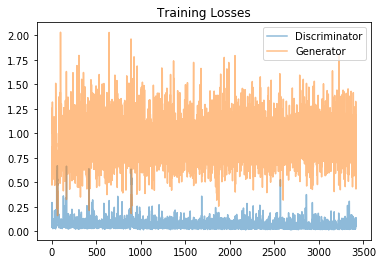

In [277]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [278]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [279]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

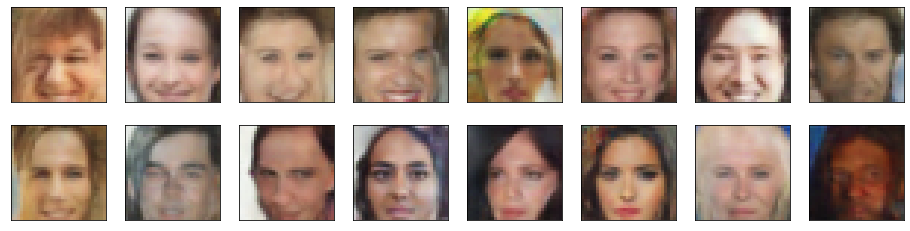

In [280]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**
1. A wider variance dataset of faces would help the generator to learn and generate also black faces and so on
2. A bigger model could allow the discriminator and the generator to get better and better by learning more features.
3. Train for more epochs, since the faces are still blurred and the losses weren't yet that stable. Discriminator and generator could also use different optimizers.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.